In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz 
from IPython import display
from IPython.display import Image
import pydotplus
from sklearn.dummy import DummyClassifier
from patsy import dmatrices, build_design_matrices, dmatrix
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

pd.set_option('display.float_format', lambda x: '%.2f' % x)

step - Maps a unit of time in the real world. In this case 1 step is 1 hour of time.  
type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER  
  
CASH-IN is the process of increasing the balance of account by paying
in cash to a merchant.  

CASH-OUT is the opposite process of CASH-IN, it means to withdraw
cash from a merchant which decreases the balance of the account.  
  
DEBIT is similar process than CASH-OUT and involves sending the
money from the mobile money service to a bank account.  
  
PAYMENT is the process of paying for goods or services to merchants
which decreases the balance of the account and increases the balance of
the receiver.  
  
TRANSFER is the process of sending money to another user of the
service through the mobile money platform.  
  
amount - amount of the transaction in local currency  
  
nameOrig - customer who started the transaction  
  
oldbalanceOrg - initial balance before the transaction  
  
newbalanceOrig - customer's balance after the transaction.  
  
nameDest - recipient ID of the transaction.  
  
oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).  
  
newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).  
  
isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.  
  
isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.  

In [2]:
# Image("/Users/randy/Downloads/Screen Shot 2019-04-26 at 10.32.16 AM.png", width='200')

When comparing Machine Fraud to Actual Fraud:
  
| Category | Machine  | Actual |
| --- | --- | --- |
| True Positive | Fraud | Fraud |
| False Positive | Fraud | Not Fraud |
| True Negative | Not Fraud | Not Fraud |
| False Negative | Not Fraud | Fraud |

In [3]:
data = pd.read_csv('/Users/randy/Downloads/PaySim_Synthetic_Dataset-Fraud.csv')

In [4]:
#I want to change all of the column names to something cleaner
df = data.rename(columns = {'step':'HoursPassed',
                          'type':'TransactionType',
                          'amount':'Amount',
                          'nameOrig':'OriginatorID',
                          'oldbalanceOrg':'OldBalORIG',
                          'newbalanceOrig':'NewBalORIG', 
                          'nameDest':'RecipientID',
                          'oldbalanceDest':'OldBalRCPT', 
                          'newbalanceDest':'NewBalRCPT', 
                          'isFraud':'Fraud',
                          'isFlaggedFraud':'FlaggedFraud'
                         })

In [5]:
#use the pandas_profiling tool to get a summary of all the data
df.describe()

# pandas_profiling.ProfileReport(df)

,HoursPassed,Amount,OldBalORIG,NewBalORIG,OldBalRCPT,NewBalRCPT,Fraud,FlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [6]:
# df[(df.values  == 'C1669947858')]
df.tail()
# df = df[df["TransactionType"].str.contains('CASH_OUT','TRANSFER') == False]

,HoursPassed,TransactionType,Amount,OriginatorID,OldBalORIG,NewBalORIG,RecipientID,OldBalRCPT,NewBalRCPT,Fraud,FlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.00,C873221189,6510099.11,7360101.63,1,0


# Initial Findings and Thoughts:

- Transfers and Cash_Out are related in many transactions. Ex. fraudsters transfer funds then cash out fast.
- In the IDs, C = Customer, M = Merchant
    - There are no Originator IDs that match Recipient IDs
    - Maybe do one-hot-encoding for C and M
- Do one-hot-encoding for Transaction Type (drop_first = True)
- One-hot-encoding (pd.get_dummies(my_series, drop_first=True)
- Feature engineering - add ratio of transaction amount to old bal
    - Ex. (ORIG) Old Bal > New Bal = negative delta
    - Ex. (RCPT) Old Bal < New Bal = positive delta
    
- Given that our data is extremely one-sided (imbalanced classification problem) The metric our intuition tells us we should maximize is known in statistics as recall, or the ability of a model to find all the relevant cases within a dataset.  
    - Not Fraud represents the overwhelming majority of the data points
    - I could have an extremely high accuracy by just saying "all are not fraud" but the recall would be terrible.

In [7]:
#no matching Originator IDs to the Recipient IDs. I assumed this means the originator is not 
df['OriginatorID'].equals(df['RecipientID'])

False

In [8]:
#create dummies for transaction types
df_trans = pd.get_dummies(df['TransactionType'],drop_first=True)
df1 = df
frames = [df1,df_trans]
result = pd.concat(frames,axis=1)

#drop the original transaction types
result = result.drop(columns=['TransactionType'])


In [9]:
#remove all numbers in Originator ID and Recipient ID
result['OriginatorID'] = result['OriginatorID'].str.replace('\d+', '')
result['RecipientID'] = result['RecipientID'].str.replace('\d+', '')

#removing all the numbers in Originator ID leaves only 'C' so I drop the whole column
result = result.drop(columns = ['OriginatorID'])

#do a get_dummies for Recipient ID since there are Merchants ('M') and Customers ('C')
result_recip = pd.get_dummies(result['RecipientID'],drop_first=True)
result1 = result
frames = [result1,result_recip]
new_result = pd.concat(frames,axis=1)

new_result = new_result.drop(columns = ['RecipientID'])


In [10]:
result_df = new_result.drop_duplicates(['Amount'],keep='last')

In [11]:
#create new columns for difference in Originator ID and Recipient ID
result_df.insert(2, 'ChangeORIG', (result_df['NewBalORIG']-result_df['OldBalORIG']))
result_df.insert(4, 'ChangeRCPT', (result_df['NewBalRCPT']-result_df['OldBalRCPT']))

#drop original ORIG and RCPT transactions
final_result = result_df.drop(columns = ['OldBalORIG','NewBalORIG','OldBalRCPT','NewBalRCPT','Amount'])
#,'TRANSFER','M','PAYMENT','HoursPassed', 'FlaggedFraud'


In [12]:
columns = [#'HoursPassed',
           'ChangeORIG',
           'ChangeRCPT',
#            'PAYMENT',
#            'CASH_OUT', #remove this for a 0.98 RF
#            'DEBIT',
#            'TRANSFER',
#           'FlaggedFraud',
           'M'
          ]



mega_result = final_result.drop(columns=columns)

In [13]:
#ok, all of the variables are now either binary or some other numerical value
# new_result.info()
# # new_result_tail.describe()
mega_result['isFraud'] = final_result['Fraud']
mega_result = mega_result.drop(columns = ['Fraud'])

ratio of Fraud to NotFraud:  0.0012924888191769902
0    5313063
1       3837
Name: isFraud, dtype: int64


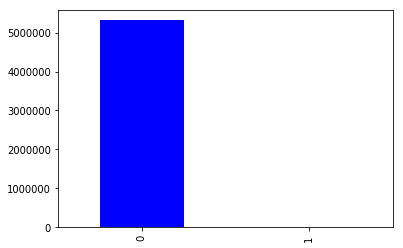

In [14]:
# data.info()
#EDA and Baselining
target_pcts = mega_result.isFraud.value_counts(normalize=False) 
print('ratio of Fraud to NotFraud: ', 8213/6354407)
print(target_pcts)

target_pcts.plot(kind='bar', color='blue');

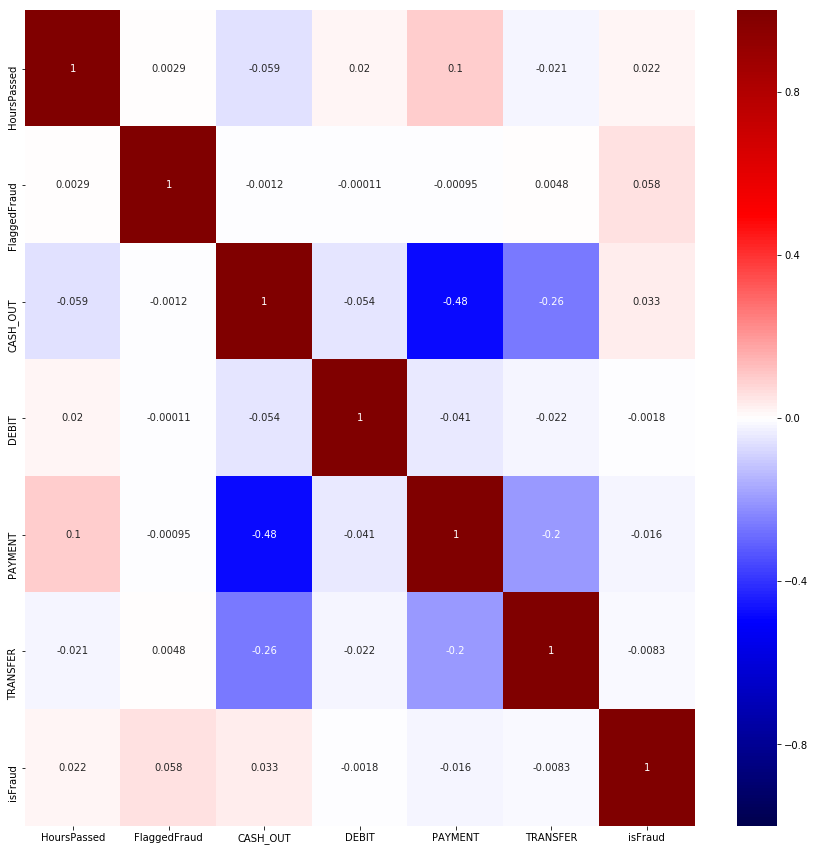

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(mega_result.corr(), cmap="seismic", ax=ax, annot=True, vmin = -1, vmax = 1)
plt.show()

In [16]:
no_fraud_result = mega_result.drop(columns=['isFraud'])

In [17]:
X_break, X_test, y_break, y_test = train_test_split(no_fraud_result, mega_result['isFraud'], \
                                                    test_size=0.2, stratify=mega_result['isFraud'],
                                                    random_state=12345)
#random_state generates a set kind of deck for each random state. 41 will always be the same kind of split

X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=12345)

In [18]:
# X_train

In [19]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train_SVC = scaler.transform(X_train)
X_val_SVC = scaler.transform(X_val)

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """


# This is where it changes. I now downsample for easier computing.

In [20]:
X_train_under, y_train_under = RandomUnderSampler(random_state=42).fit_sample(X_train,y_train)
X_val_under, y_val_under = RandomUnderSampler(random_state=42).fit_sample(X_val,y_val)
X_train_under_SVC, y_train_under_SVC = RandomUnderSampler(random_state=42).fit_sample(X_train_SVC,y_train)

In [21]:
Counter(y_train_under) #check to see that the samples are the same size

Counter({0: 2303, 1: 2303})

In [22]:
# Run CV with 5 folds (knn)

ks = [1,5,10]
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
knn_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    1.3s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:    1.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    1.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:    1.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    1.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapse

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': [1, 5, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc',
       verbose=30)

True Positive - marked as fraud, is fraud  
False Positive - marked as fraud, is legit  
True Negative - marked as legit, is legit  
False Negative - marked as legit, is fraud

In [23]:
fraud_only = result_df[result_df['Fraud'] == 1]

In [24]:
#loss per missed fraud (recall is much more valuable)
loss_per_fraud = round(np.mean(fraud_only['Amount']))

In [25]:
loss_per_fraud

1204813

In [26]:
#we're going to assume this is 
#transactions per consumer 
transaction_per_consumer = round(np.mean(result_df['Amount']))

In [27]:
transaction_per_consumer

202228

In [28]:
def make_confusion_matrix(model, threshold=0.5):
    plt.rcParams.update({'font.size': 10})
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_val_under, y_predict)
    plt.figure(dpi=200)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Fraud', 'Fraud'],
  
           yticklabels=['Not Fraud', 'Fraud']);
    TP = fraud_confusion[0][0]
    FP = fraud_confusion[0][1]
    FN = fraud_confusion[1][0]
    TN = fraud_confusion[1][1]
    plt.yticks(rotation = 0)
    print('Cost of a legitimate transaction marked as fraud (False Positive) : $', FP*transaction_per_consumer)
    print('')
    print('Cost of fraud marked as a legitimate transaction (False Negative) : $', FN*transaction_per_consumer)
    plt.title('Predicted vs. Actual',fontname = '.SF Compact Display',fontsize = 25,pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual',rotation = 0)
#     plt.rcParams.update({'font.size': 20})


In [29]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training set: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Validation set: {:6.2f}%".format(100*logit.score(X_val, y_val)))

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training set:  99.93%
Validation set:  99.93%


In [65]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(CV_rfc, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [31]:
# using the new threshold of n
def check_threshold(n):
    y_predict = (logit.predict_proba(X_val_under)[:,1] > float(n))
    print(f'Threshold of {n}:')
    print('Precision: {:6.4f},   Recall: {:6.4f}'.format(precision_score(y_val_under, y_predict), 
                                                     recall_score(y_val_under, y_predict)))
    print(f'Total Score: {precision_score(y_val_under, y_predict) + recall_score(y_val_under, y_predict)}')
    print('')

In [32]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logit.predict(X_val_under)
print("Default threshold: 0.5")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val_under, y_predict), 
                                                     recall_score(y_val_under, y_predict)))

Default threshold: 0.5
Precision: 0.0000,   Recall: 0.0000


/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
for item in np.arange(0.0, 1.0, 0.02):
    check_threshold(item)

Threshold of 0.0:
Precision: 0.5000,   Recall: 1.0000
Total Score: 1.5

Threshold of 0.02:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.04:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.06:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.08:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.1:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.12:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.14:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.16:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.18:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.2:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.22:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.24:
Precision: 0.0000,   Recall: 0.0000
Total Score: 0.0

Threshold of 0.26:
Precision: 0.0000,   Recall: 0.0000

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/randy/anaconda3/lib/python3.7/site-packages/s

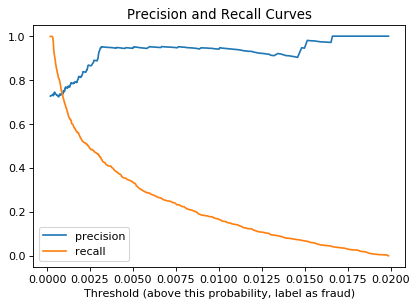

In [34]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_under, logit.predict_proba(X_val_under)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

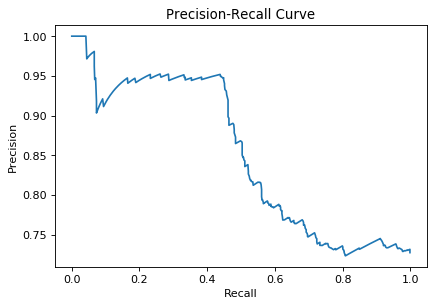

In [35]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

# The ROC Curve

In [36]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 



In [37]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0886s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([    1.     ,     2.78256,     7.74264,    21.54435,    59.94843,
         166.81005,   464.15888,  1291.54967,  3593.81366, 10000.     ]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=30)

In [38]:
# # Run CV with 5 folds (SVM). Unsure if I can run this given how long it takes

C = [1,2,5,10]
gammas = [0.001, 0.1]
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
svm_grid.fit(X_train_under, y_train_under)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Paralle

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 2, 5, 10], 'gamma': [0.001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=30)

In [39]:
# Run CV with 5 folds (Random Forest)

# Number of trees in random forest
n_estimators = [100,250,500]#[200, 250] #200 or 250 models. test this more
# Number of features to consider at every split
max_features = ['auto'] #sqrt
# Maximum number of levels in tree
max_depth = [40,80,200]#[70, 80]
# Minimum number of samples required to split a node
min_samples_split = [5,10]#[2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4]#[1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth, #how deep the tree gets to go, test this more
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

# #looking for the best hyperparams
# #Create base model to tune
rfc=RandomForestClassifier()

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=30, n_jobs=-1)
CV_rfc.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   14.9s
[Paralle

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 250, 500], 'max_features': ['auto'], 'max_depth': [40, 80, 200], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=30)

In [40]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train_under, y_train_under)

In [41]:
# # Fit sub_grade Classifier

# isFraud = 'isFraud'
# x_patsy_sg = dmatrix(isFraud, X_train)
#x_patsy_sg_test = x_patsy_sg[test_index,:]
# x_patsy_sg_val = x_patsy_sg[y_val,:]
# x_patsy_sg_train = x_patsy_sg[y_train,:]

# logistic_sub_grade = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
# logistic_sub_grade.fit(x_patsy_sg_train, y_train)
# logistic_sub_grade.coef_

In [42]:
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % CV_rfc.best_score_)

Best ROC_AUC for logit: 0.8778
Best ROC_AUC for svm: 0.9158
Best ROC_AUC for rf: 0.8495


In [43]:
print('Best Params for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', CV_rfc.best_params_)

Best Params for logit:  {'C': 59.94842503189409, 'penalty': 'l2'}
Best Params for svm:  {'C': 5, 'gamma': 0.1}
Best Params for rf:  {'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 250}


In [44]:
dc = DummyClassifier()
dc.fit(X_train_under, y_train_under)
# print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_val, dc.predict_proba(X_val))))

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [45]:
# final_result.loc[final_result['isFraud'] == 1].mean()

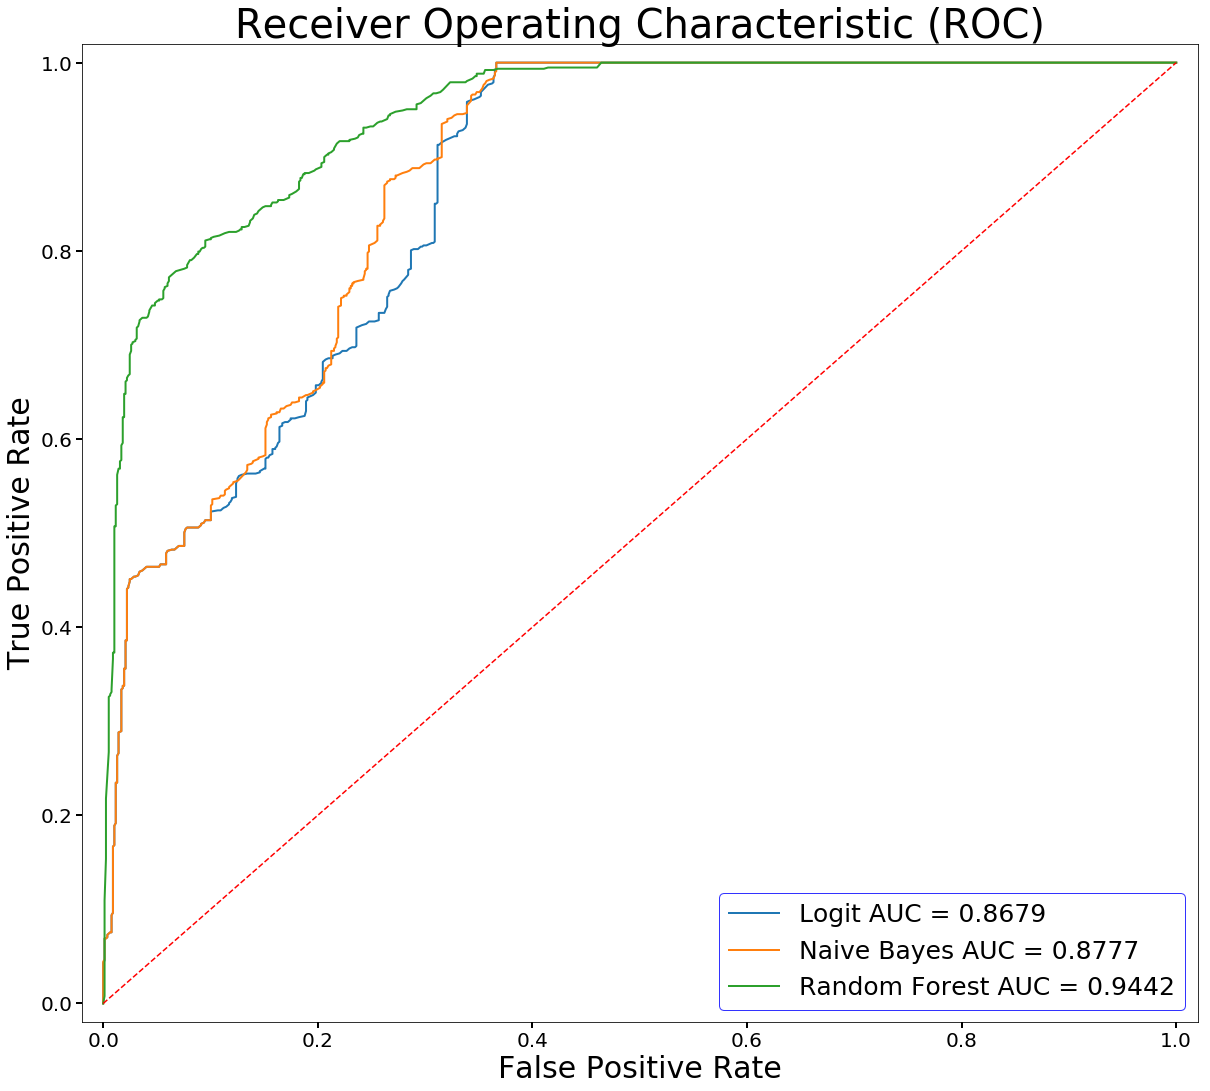

In [46]:
#in sample
plt.rcParams.update({'font.size': 30})
model_list = [logistic_grid.best_estimator_, 
#              svm_grid.best_estimator_, 
              gnb_best,
#               rf_random.best_estimator_,
#              knn_grid.best_estimator_,
              CV_rfc.best_estimator_,
#              dc
             ]

model_name = ['Logit','Naive Bayes', 'Random Forest']#,'KNN' 'SVM',,'Dummy'
 
# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(20,18))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_val_under)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val_under, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=2.0)
ax.grid(False)
ax.tick_params(length=6, width=2,labelsize = 20,
               grid_color='r', grid_alpha=0.5)
# plt.legend(loc = 'lower right',prop={'size': 25})
leg = plt.legend(loc = 'lower right',prop={'size': 25})
leg.get_frame().set_edgecolor('b')
plt.title('Receiver Operating Characteristic (ROC)', FontSize=40)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-.02, 1.02])
plt.ylim([-.02, 1.02])
plt.ylabel('True Positive Rate',FontSize=30)
plt.xlabel('False Positive Rate',FontSize=30)
plt.show()

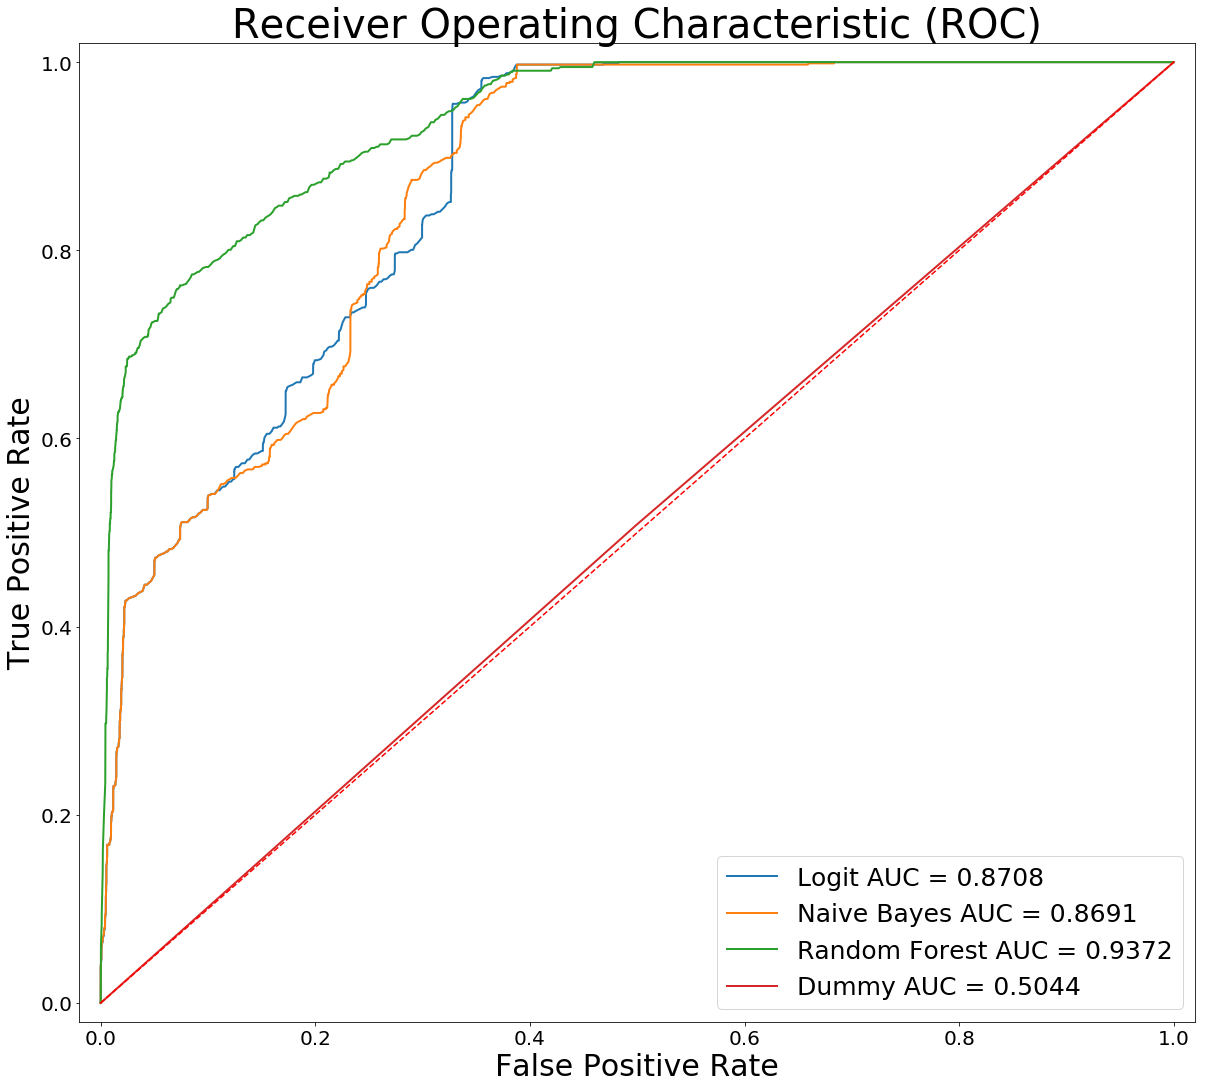

In [47]:
#out of sample
plt.rcParams.update({'font.size': 20})
model_list = [logistic_grid.best_estimator_, 
#              svm_grid.best_estimator_, 
              gnb_best,
#               rf_random.best_estimator_,
#               knn_grid.best_estimator_,
              CV_rfc.best_estimator_,
             dc]

model_name = ['Logit','Naive Bayes', 'Random Forest','Dummy']#,'KNN' 'SVM',
 
# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(20,18))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=2.0)

plt.legend(loc = 'lower right',prop={'size': 25})
plt.title('Receiver Operating Characteristic (ROC)', FontSize=40)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-.02, 1.02])
plt.ylim([-.02, 1.02])
plt.ylabel('True Positive Rate', FontSize=30)
plt.xlabel('False Positive Rate', FontSize=30)
plt.show()

In [48]:
for item1,item2 in zip(X_test.columns,CV_rfc.best_estimator_.feature_importances_):
    print(f'{item1} has a score of {item2}')

HoursPassed has a score of 0.471699381067303
FlaggedFraud has a score of 0.00442785909589384
CASH_OUT has a score of 0.41236573893265743
DEBIT has a score of 0.0008494693633096843
PAYMENT has a score of 0.09069628901097947
TRANSFER has a score of 0.01996126252985669


# Finding the F1 score and Threshold

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

model_dict = {'rfc': RandomForestClassifier(n_estimators = 400, n_jobs = -1,max_features = 'sqrt'),
             'lm' : LogisticRegression(max_iter =10000,solver='sag',verbose = 10,n_jobs = -1),
             'gnb' : GaussianNB(),
             'mlp' : MLPClassifier(verbose = 10),
             'gbc' : GradientBoostingClassifier(n_estimators =  1000, max_leaf_nodes = 4,\
                                                max_depth = None ,min_samples_split = 5, verbose = 10,
                                               learning_rate = .1)}

In [50]:
def make_model(mdl_key,X_train,y_train,X_test):
    """Uses key from model_dict and trains it on X_train, y_train, then returns \
    the model object used and predicted values on X_test"""
    assert (mdl_key in model_dict.keys()),"Model tag not in model_dict keys!"
    mdl = model_dict[mdl_key]
    mdl.fit(X_train,y_train)
    predicted = mdl.predict(X_test)
    return mdl, predicted

In [51]:
rfc, gnb_predicted = make_model('rfc',X_train_under,y_train_under,X_val_under)

In [52]:
lm, predicted = make_model('lm',X_train_under,y_train_under,X_val_under)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 3440 epochs took 3 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished


In [53]:
gnb, gnb_predicted = make_model('gnb',X_train_under,y_train_under,X_val_under)

In [54]:
mlp, mlp_predicted = make_model('mlp',X_train_under,y_train_under,X_val_under)

Iteration 1, loss = 3.24271507
Iteration 2, loss = 0.80543630
Iteration 3, loss = 0.66699482
Iteration 4, loss = 0.64743825
Iteration 5, loss = 0.63060321
Iteration 6, loss = 0.61914189
Iteration 7, loss = 0.63176506
Iteration 8, loss = 0.59905240
Iteration 9, loss = 0.57532001
Iteration 10, loss = 0.57911097
Iteration 11, loss = 0.56900447
Iteration 12, loss = 0.53878138
Iteration 13, loss = 0.54392348
Iteration 14, loss = 0.53731369
Iteration 15, loss = 0.51164976
Iteration 16, loss = 0.52098504
Iteration 17, loss = 0.49226857
Iteration 18, loss = 0.48970494
Iteration 19, loss = 0.47765754
Iteration 20, loss = 0.47193793
Iteration 21, loss = 0.46770227
Iteration 22, loss = 0.46972905
Iteration 23, loss = 0.45911293
Iteration 24, loss = 0.46476529
Iteration 25, loss = 0.45238986
Iteration 26, loss = 0.47958526
Iteration 27, loss = 0.45022673
Iteration 28, loss = 0.44128953
Iteration 29, loss = 0.44601794
Iteration 30, loss = 0.44551204
Iteration 31, loss = 0.44912270
Iteration 32, los

In [55]:
gbc, gbc_predicted = make_model('gbc',X_train_under,y_train_under,X_val_under)

      Iter       Train Loss   Remaining Time 
         1           1.2837            2.31s
         2           1.1999            1.99s
         3           1.1302            1.89s
         4           1.0716            1.87s
         5           1.0217            1.77s
         6           0.9789            1.74s
         7           0.9420            1.70s
         8           0.9100            1.71s
         9           0.8822            1.71s
        10           0.8578            1.68s
        11           0.8362            1.63s
        12           0.8174            1.61s
        13           0.8007            1.58s
        14           0.7854            1.55s
        15           0.7716            1.53s
        16           0.7594            1.51s
        17           0.7483            1.50s
        18           0.7387            1.49s
        19           0.7296            1.48s
        20           0.7214            1.47s
        21           0.7141            1.48s
        2

       221           0.5255            1.19s
       222           0.5251            1.19s
       223           0.5249            1.18s
       224           0.5247            1.18s
       225           0.5246            1.18s
       226           0.5241            1.18s
       227           0.5235            1.17s
       228           0.5231            1.17s
       229           0.5227            1.17s
       230           0.5226            1.17s
       231           0.5224            1.17s
       232           0.5217            1.17s
       233           0.5214            1.16s
       234           0.5213            1.16s
       235           0.5212            1.16s
       236           0.5209            1.16s
       237           0.5207            1.16s
       238           0.5207            1.15s
       239           0.5205            1.15s
       240           0.5202            1.15s
       241           0.5196            1.15s
       242           0.5192            1.15s
       243

       417           0.4809            0.84s
       418           0.4806            0.84s
       419           0.4805            0.84s
       420           0.4803            0.84s
       421           0.4802            0.84s
       422           0.4801            0.84s
       423           0.4801            0.84s
       424           0.4799            0.84s
       425           0.4798            0.84s
       426           0.4797            0.83s
       427           0.4796            0.83s
       428           0.4795            0.83s
       429           0.4794            0.83s
       430           0.4794            0.83s
       431           0.4793            0.83s
       432           0.4792            0.83s
       433           0.4792            0.82s
       434           0.4789            0.82s
       435           0.4787            0.82s
       436           0.4786            0.82s
       437           0.4785            0.82s
       438           0.4784            0.82s
       439

       620           0.4592            0.58s
       621           0.4591            0.58s
       622           0.4591            0.57s
       623           0.4591            0.57s
       624           0.4591            0.57s
       625           0.4590            0.57s
       626           0.4589            0.57s
       627           0.4588            0.57s
       628           0.4588            0.57s
       629           0.4587            0.56s
       630           0.4587            0.56s
       631           0.4586            0.56s
       632           0.4586            0.56s
       633           0.4586            0.56s
       634           0.4585            0.56s
       635           0.4585            0.55s
       636           0.4584            0.55s
       637           0.4583            0.55s
       638           0.4582            0.55s
       639           0.4581            0.55s
       640           0.4581            0.55s
       641           0.4580            0.55s
       642

       865           0.4452            0.21s
       866           0.4452            0.21s
       867           0.4452            0.21s
       868           0.4451            0.21s
       869           0.4451            0.20s
       870           0.4450            0.20s
       871           0.4450            0.20s
       872           0.4450            0.20s
       873           0.4449            0.20s
       874           0.4449            0.20s
       875           0.4449            0.19s
       876           0.4449            0.19s
       877           0.4448            0.19s
       878           0.4448            0.19s
       879           0.4448            0.19s
       880           0.4447            0.19s
       881           0.4447            0.18s
       882           0.4447            0.18s
       883           0.4447            0.18s
       884           0.4447            0.18s
       885           0.4446            0.18s
       886           0.4446            0.18s
       887

In [56]:
# Fit random forest to basic model (sub_grade only)
rfc_b = RandomForestClassifier()
rfc_b.fit(X_train_under,y_train_under)
predicted_b = rfc_b.predict(X_val_under)

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [57]:
def find_best_threshold(model, int_num_steps):
    highest_f1 = 0
    best_threshold = 0
    for threshold in np.linspace (0, 1, int_num_steps):
        y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold) 
        f1 = f1_score(y_val_under,y_predict)
        if f1 > highest_f1:
            best_threshold, highest_f1 = threshold, f1
    return best_threshold, highest_f1

In [58]:
best_thresh, high_f1 = find_best_threshold(rfc,20)
print('Best Threshold: ', best_thresh)
print('Highest_f1: ', high_f1)

Best Threshold:  0.3157894736842105
Highest_f1:  0.8516516516516517


In [59]:
# Examine the correlation of the model errors

knn_error = y_train_under - knn_grid.predict_proba(X_train_under)[:,1]
logit_error = y_train_under - logistic_grid.predict_proba(X_train_under)[:,1]
svm_error = y_train_under - svm_grid.predict_proba(X_train_under)[:,1]
gnb_error = y_train_under - gnb_best.predict_proba(X_train_under)[:,1]
rf_error = y_train_under - CV_rfc.predict_proba(X_train_under)[:,1]

error_df = pd.DataFrame()
error_df['knn'] = knn_error
error_df['logit'] = logit_error
error_df['svm'] = svm_error
error_df['gnb'] = gnb_error
error_df['rand_forest'] = rf_error

error_df.corr()

,knn,logit,svm,gnb,rand_forest
knn,1.00,0.70,0.83,0.60,0.92
logit,0.70,1.00,0.66,0.90,0.78
svm,0.83,0.66,1.00,0.49,0.89
gnb,0.60,0.90,0.49,1.00,0.70
rand_forest,0.92,0.78,0.89,0.70,1.00


In [60]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [61]:
features = []
for item in X_train.columns:
    features.append(item)

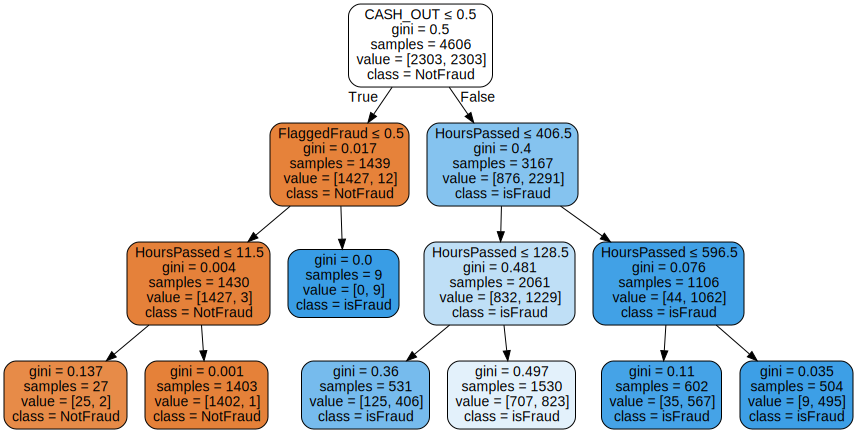

In [62]:
clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=3)
clf = clf.fit(X_train_under, y_train_under)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Fraud") 

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      class_names=['NotFraud','isFraud'], 
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Log Loss Cross-Entropy

_A more intensive metric for measuring the performance of your models._ So far, everything we've discussed uses "hard-predictions" to determine how well the model is doing. You apply some threshold and decided, "yes, I believe this is class XYZ" before checking to see if it's actually XYZ. 

That's an okay method, but it doesn't really give us a sense of how close the model was to being wrong. E.g., if we have a threshold of `0.5` and a record that's actually class 1, precision, recall, accuracy, etc. all give equal credit to a prediction that got the class correct, whether it was with `p = 0.51` or `p=0.99`. The second is much higher confidence though! 

Similarly, they give equal penalty to `p = 0.49` and `p=0.01`, though we were much more confident (in the wrong direction) in the second case. Guesses around `0.5` shouldn't be penalized as much, because our model is already admitting "hey, I don't really know what this observation is." 

Enter log-loss. For the binary case, we can define log-loss:

$$ LLCE = - \sum_{i=1}^{N} y \cdot log(p_{y}) + (1-y) \cdot log((1-p_{y}))$$

What does this do? It says, "If the class is actually 1, did you predict close to p=1? If not, that's a big penalty. Though, we'll penalize you way more if you predicted close to p=0. If the class is actually 0, did you predict close to p=0? If not, that's another big penalty."

The main take-aways here are:

>- Log-loss allows us to measure not just "did our model get XYZ right?" but "how confident was it in when predicting?"
>
>- A lower log-loss is better

The cost function typically used for Gradient Descent on classification is log-loss-cross-entropy!

# Plotly 

In [63]:
# load packages
import sklearn
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

In [64]:
# import some data to play with
X = X_train_under  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = y_train_under

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', verbose=30, gamma='auto' C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf',verbose=30, gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly',verbose=30, degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(verbose=30,C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x_ = np.arange(x_min, x_max) #,h
y_ = np.arange(y_min, y_max) #,h
xx, yy = np.meshgrid(x_, y_)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

SyntaxError: invalid syntax (<ipython-input-64-439889fc018a>, line 11)

In [ ]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

cmap = matplotlib_to_plotly(plt.cm.coolwarm, 5)

fig = tools.make_subplots(rows=2, cols=2,
                          print_grid=False,
                          subplot_titles=titles)

In [ ]:
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    p1 = go.Contour(x=x_, y=y_, z=Z, 
                    colorscale=cmap,
                    showscale=False)
    fig.append_trace(p1, i/2+1, i%2+1)

    # Plot also the training points
    p2 = go.Scatter(x=X[:, 0], y=X[:, 1], 
                    mode='markers',
                    marker=dict(color=y,
                                colorscale=cmap,
                                showscale=False,
                                line=dict(color='black', width=1))
                   )   
    fig.append_trace(p2, i/2+1, i%2+1)

In [ ]:
for i in map(str, range(1, 5)):
    y = 'yaxis'+ i
    x = 'xaxis'+i
    fig['layout'][y].update(showticklabels=False, ticks='',
                            title="Sepal Length")
    fig['layout'][x].update(showticklabels=False, ticks='',
                            title="Sepal Width")

fig['layout'].update(height=700, showlegend=False)

py.iplot(fig)